In [7]:
using ReinforcementLearningCore, RLIntro, RLIntro.RandomWalk
using StatsBase
using Plots

In [3]:
env = RandomWalkEnv(N=21)
ns = length(get_observation_space(env))
na = length(get_action_space(env))
true_values = -1:0.1:1

-1.0:0.1:1.0

In [4]:
struct RecordRMS <: AbstractHook
    rms::Vector{Float64}
    RecordRMS() = new([])
end

(f::RecordRMS)(::PostEpisodeStage, agent, env, obs) = push!(f.rms, sqrt(mean((agent.policy.value_learner.approximator.table[2:end-1] - true_values[2:end-1]).^2)))

In [12]:
function run_once(α, n)
    env = RandomWalkEnv(N=21)
    agent = Agent(
        policy=VBasedPolicy(
            value_learner=TDLearner(
                approximator=TabularApproximator(n_state=ns),
                optimizer=Descent(α),
                method=:SRS,
                n=n
                ),
            mapping= (obs, V) -> begin
                values = zeros(na)
                values[rand(1:na)] = 1.0
                values
            end
            ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(10; is_show_progress=false), hook)
    mean(hook.rms)
end

run_once (generic function with 1 method)

In [22]:
run_once(0.1, 1)

0.4732476996537157

In [5]:
run_once(0.1, 1)

0.4804389094387056

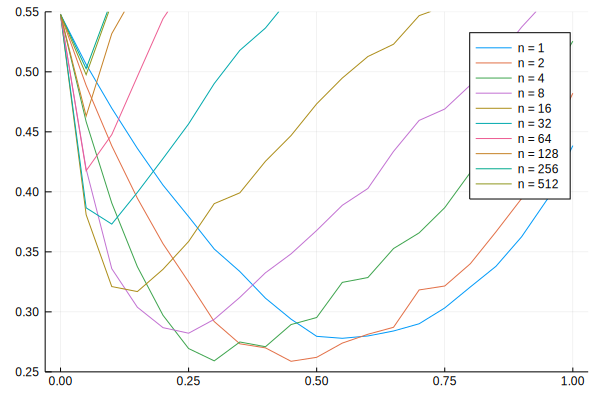

In [23]:
A = 0.:0.05:1.0
p = plot()
for n in [2^i for i in 0:9]
    avg_rms = Float64[]
    for α in A
        rms = []
        for _ in 1:100
            push!(rms, run_once(α, n))
        end
        push!(avg_rms, mean(rms))
    end
    plot!(p, A, avg_rms, label="n = $n")
end
p

ylims!(p, 0.25, 0.55)